# Описание
с помощью pandahouse выгрузить нужные данные из ClickHouse и проанализировать их в python.

## Задачи:
1. Выгрузить из таблицы данные о цене в зависимости от типа жильяю Посчитать 75 процентиль цены по типу жилья.
2. К данным о цене и типе комнаты дополнительно выгрузить данные о рейтинге жилья (review_scores_rating). Построить график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.
3. Какие пособы верификации аккаунта использовали хозяева, предлагающие различные впечатления? Сколько хозяев подтвердили профиль с помощью аккаунта Google?
4. Для скольких объявлений и в каких районах хозяева указали впечатления?
5. Выгрузить данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления.
6. Выгрузить данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Построить график динамики средних цен на жилье в зависимости от типа комнаты по годам.

In [1]:
import pandas as pd
import numpy as np
import pandahouse as ph
from datetime import date
import holidays
import prophet
import seaborn as sns
import matplotlib.pyplot as plt
import ast

In [17]:
connection = {'host': 'http://clickhouse.*****',
                      'database':'****',
                      'user':'****', 
                      'password':'****'
                     }

In [ ]:
# Step_1. Выгрузить из таблицы данные о цене в зависимости от типа жильяю Посчитать 75 процентиль цены по типу жилья.

In [3]:
query = """
SELECT 
    toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) as price,
    room_type
FROM default.ldn_listings
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)


In [4]:
df.groupby('room_type').quantile(0.75)

,price
room_type,
Entire home/apt,160.00
Hotel room,157.00
Private room,70.00
Shared room,69.25


In [ ]:
# Step_2. К данным о цене и типе комнаты дополнительно выгрузить данные о рейтинге жилья (review_scores_rating). 
# Построить график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.

In [83]:
query = """
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) as price,
    toFloat32OrNull(review_scores_rating) as review
FROM default.ldn_listings
WHERE toFloat32OrNull(review_scores_rating) IS NOT NULL
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)


In [91]:
df

,room_type,price,review
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0
...,...,...,...
995,Entire home/apt,165.0,100.0
996,Private room,99.0,93.0
997,Private room,45.0,100.0
998,Private room,20.0,88.0


In [88]:
gdf = df.groupby('room_type').agg({'price':'mean', 'review':'mean'})

<AxesSubplot:xlabel='price', ylabel='review'>

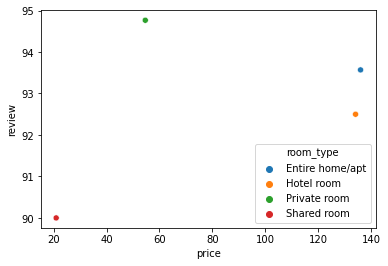

In [95]:
sns.scatterplot(data=gdf, x='price', y='review', hue='room_type')

In [94]:
# Step_3. Какие пособы верификации аккаунта использовали хозяева, предлагающие различные впечатления? 
# Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [6]:
query = """
SELECT DISTINCT
    host_id,
    host_verifications 
FROM default.ldn_listings
WHERE experiences_offered != 'none'
"""
df = ph.read_clickhouse(query, connection=connection)


In [139]:
df

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
995,22611343,"['email', 'phone', 'manual_online', 'reviews',..."
996,17714749,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
997,22648205,"['email', 'phone']"
998,22714079,"['email', 'phone', 'reviews', 'jumio', 'govern..."


In [7]:
# преобразуем строку со сопособами верификаций в список с помшью ast.literal_eval
for i in range(len(df.host_verifications)):
    df.host_verifications[i] = ast.literal_eval(df.host_verifications[i])

C:\Users\pakievskij\AppData\Local\Temp\ipykernel_6064\478662456.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.host_verifications[i] = ast.literal_eval(df.host_verifications[i])


In [146]:
# "взрываем" стрку на отдельные значения и смотрим количество вариантов
df.host_verifications.explode().value_counts()

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

In [147]:
# Step_4. Для скольких объявлений и в каких районах хозяева указали впечатления?

In [149]:
query = """
SELECT DISTINCT
     neighbourhood_cleansed,
      experiences_offered,
      count() as experiences_count
FROM default.ldn_listings
WHERE experiences_offered != 'none'
GROUP BY neighbourhood_cleansed, experiences_offered
ORDEr BY experiences_count DESC
LIMIT 100 
"""
df = ph.read_clickhouse(query, connection=connection)


In [150]:
df

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Lewisham,romantic,2
97,Harrow,family,1
98,Hillingdon,social,1


In [157]:
# группируем данные в сводную таблицу
pivot = df.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')

<AxesSubplot:xlabel='experiences_offered', ylabel='neighbourhood_cleansed'>

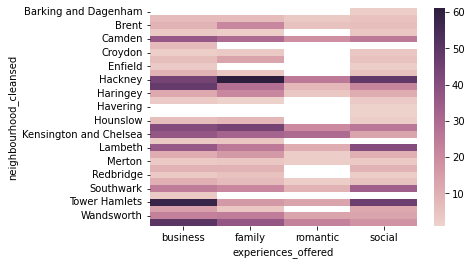

In [158]:
# строим тепловую карту, чтобы удобно визуализировать количество и тип впечатленйи по районам.
sns.heatmap(pivot, cmap=sns.cubehelix_palette(as_cmap=True))

In [ ]:
# Step_5. Выгрузить данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления.

In [8]:
query = """
SELECT DISTINCT
     room_type,
     toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) as price
     FROM default.ldn_listings
WHERE experiences_offered != 'none'
"""
df = ph.read_clickhouse(query, connection=connection)

In [16]:
df.head()

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0


In [9]:
df.room_type.value_counts()

Entire home/apt    187
Private room        94
Shared room          8
Hotel room           3
Name: room_type, dtype: int64

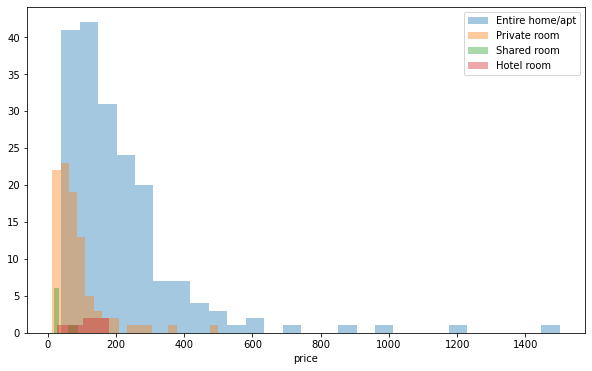

In [14]:
# построим распределения цен по каждому типу жилья
plt.figure(figsize=(10,6))

sns.distplot(df.query("room_type=='Entire home/apt'").price, kde=False,label='Entire home/apt')
sns.distplot(df.query("room_type=='Private room'").price, kde=False, label='Private room')
sns.distplot(df.query("room_type=='Shared room'").price, kde=False, label='Shared room')
sns.distplot(df.query("room_type=='Hotel room'").price, kde=False, label='Hotel room')             


plt.legend()
plt.show()

In [191]:
# Step_6. Выгрузить данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. 
# Построить график динамики средних цен на жилье в зависимости от типа комнаты по годам.

In [204]:
query = """
SELECT DISTINCT
     room_type,
     toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) as price,
     first_review
FROM default.ldn_listings
WHERE first_review  > '2010-01-01'
LIMIT 1000 
"""
df = ph.read_clickhouse(query, connection=connection)

In [209]:
df

,room_type,price,first_review
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010
...,...,...,...
995,Private room,99.0,2012
996,Private room,45.0,2015
997,Entire home/apt,100.0,2016
998,Entire home/apt,55.0,2013


In [207]:
df['first_review'] = pd.to_datetime(df.first_review)

In [208]:
df['first_review'] = df.first_review.dt.year

<AxesSubplot:xlabel='first_review', ylabel='price'>

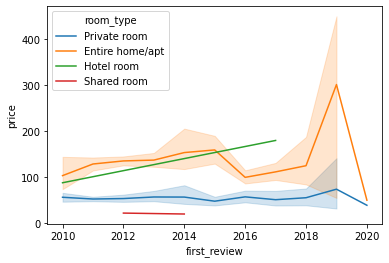

In [211]:
sns.lineplot(y=df.price, x=df.first_review, hue=df.room_type)